In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import requests
import json
import gmaps
from scipy.stats import linregress
import seaborn as sns
import dateutil.parser
from pandas import Timestamp
from census import Census

api_key = 'b32af77e6ab68503130abf640cd428c259b88877'
# Census API Key
#from config import api_key
c = Census(api_key, year=2016)

from config import gkey

## Population Density

In [2]:
#getting the data in
accident_data = pd.read_csv('US_Accidents_June20_Full.csv')
accident_data.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [3]:
#shrinking the data to the relevant stats
zipcodes = accident_data[['ID', 'Start_Lat', 'Start_Lng', 'Zipcode', 'City', 'State']]
zipcodes['Zipcode'] = zipcodes['Zipcode'].str[:5]
zipcodes['citystate'] = zipcodes['City']+', '+zipcodes['State']
zipcodes.head()

<ipython-input-3-5825345a92e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zipcodes['Zipcode'] = zipcodes['Zipcode'].str[:5]
<ipython-input-3-5825345a92e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zipcodes['citystate'] = zipcodes['City']+', '+zipcodes['State']


,ID,Start_Lat,Start_Lng,Zipcode,City,State,citystate
0,A-1,39.865147,-84.058723,45424,Dayton,OH,"Dayton, OH"
1,A-2,39.928059,-82.831184,43068,Reynoldsburg,OH,"Reynoldsburg, OH"
2,A-3,39.063148,-84.032608,45176,Williamsburg,OH,"Williamsburg, OH"
3,A-4,39.747753,-84.205582,45417,Dayton,OH,"Dayton, OH"
4,A-5,39.627781,-84.188354,45459,Dayton,OH,"Dayton, OH"


In [4]:
#Inspecting the number of individual zipcodes in the data
unique_zipcodes = zipcodes['Zipcode'].unique()
print(len(unique_zipcodes))

21353


In [5]:
#Finding the number of accidents in each zipcode (ID column)
zipcount = zipcodes.groupby('Zipcode').agg({'Start_Lat': 'mean', 'Start_Lng': 'mean', 'ID': 'count'})
zipcount.head()

,Start_Lat,Start_Lng,ID
Zipcode,,,
01001,42.074324,-72.612986,13
01002,42.375306,-72.521698,22
01003,42.384808,-72.532578,1
01005,42.409579,-72.113702,18
01007,42.280653,-72.413924,23


In [6]:
#Getting population data for each zip code
census_data = c.acs5.get(("NAME", "B01003_001E"), {'for': 'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)

census_pd = census_pd.rename(columns={"B01003_001E": "Population", "NAME": "Name", "zip code tabulation area": "Zipcode"})

#print(len(census_pd)
census_pd.head()


,Name,Population,Zipcode
0,ZCTA5 37064,54462.0,37064
1,ZCTA5 37066,46969.0,37066
2,ZCTA5 37067,26841.0,37067
3,ZCTA5 37069,19522.0,37069
4,ZCTA5 37072,31914.0,37072


In [7]:
#Creating bins for the population data
bins = np.arange(0, 120000, 5000).tolist()
group_names = ['Up to '+str(num) for num in bins][1:]

census_pd["Zipcode Pop"] = pd.cut(census_pd["Population"], bins, labels=group_names, include_lowest=True)
census_pd.head()

,Name,Population,Zipcode,Zipcode Pop
0,ZCTA5 37064,54462.0,37064,Up to 55000
1,ZCTA5 37066,46969.0,37066,Up to 50000
2,ZCTA5 37067,26841.0,37067,Up to 30000
3,ZCTA5 37069,19522.0,37069,Up to 20000
4,ZCTA5 37072,31914.0,37072,Up to 35000


In [8]:
#Creating a dataframe with accidents by zipcode
merged_data = pd.merge(census_pd, zipcount, on='Zipcode', how='left')
merged_data.head()

,Name,Population,Zipcode,Zipcode Pop,Start_Lat,Start_Lng,ID
0,ZCTA5 37064,54462.0,37064,Up to 55000,35.873466,-86.850015,258.0
1,ZCTA5 37066,46969.0,37066,Up to 50000,36.400493,-86.465493,29.0
2,ZCTA5 37067,26841.0,37067,Up to 30000,35.934524,-86.815756,185.0
3,ZCTA5 37069,19522.0,37069,Up to 20000,35.963860,-86.860012,23.0
4,ZCTA5 37072,31914.0,37072,Up to 35000,36.321777,-86.711887,877.0


In [9]:
#Plugging NaNs, want to keep the rows to get their population later
merged_data['Start_Lat'] = merged_data['Start_Lat'].fillna(0)
merged_data['Start_Lng'] = merged_data['Start_Lng'].fillna(0)
merged_data['ID'] = merged_data['ID'].fillna(0)
merged_data['Rate'] = merged_data['ID']/merged_data['Population']*1000
merged_data['Rate'] = merged_data['Rate'].fillna(0)
#merged_data['Accident_Rate'] = merged_data['Accident_Rate'].fillna(0)
merged_data.head()

,Name,Population,Zipcode,Zipcode Pop,Start_Lat,Start_Lng,ID,Rate
0,ZCTA5 37064,54462.0,37064,Up to 55000,35.873466,-86.850015,258.0,4.737248
1,ZCTA5 37066,46969.0,37066,Up to 50000,36.400493,-86.465493,29.0,0.617429
2,ZCTA5 37067,26841.0,37067,Up to 30000,35.934524,-86.815756,185.0,6.892441
3,ZCTA5 37069,19522.0,37069,Up to 20000,35.963860,-86.860012,23.0,1.178158
4,ZCTA5 37072,31914.0,37072,Up to 35000,36.321777,-86.711887,877.0,27.480103


In [10]:
locations = merged_data[['Start_Lat', 'Start_Lng']]

incidents = merged_data['Rate']
merged_data.head(50)

,Name,Population,Zipcode,Zipcode Pop,Start_Lat,Start_Lng,ID,Rate
0,ZCTA5 37064,54462.0,37064,Up to 55000,35.873466,-86.850015,258.0,4.737248
1,ZCTA5 37066,46969.0,37066,Up to 50000,36.400493,-86.465493,29.0,0.617429
2,ZCTA5 37067,26841.0,37067,Up to 30000,35.934524,-86.815756,185.0,6.892441
3,ZCTA5 37069,19522.0,37069,Up to 20000,35.963860,-86.860012,23.0,1.178158
4,ZCTA5 37072,31914.0,37072,Up to 35000,36.321777,-86.711887,877.0,27.480103
5,ZCTA5 37073,14086.0,37073,Up to 15000,36.422889,-86.778546,9.0,0.638932
6,ZCTA5 37074,7016.0,37074,Up to 10000,36.366569,-86.167210,2.0,0.285063
7,ZCTA5 37075,63452.0,37075,Up to 65000,36.317888,-86.645201,110.0,1.733594
8,ZCTA5 37076,37814.0,37076,Up to 40000,36.181165,-86.605362,1462.0,38.662929
9,ZCTA5 37078,462.0,37078,Up to 5000,35.881983,-87.770568,16.0,34.632035


In [11]:
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights = incidents, dissipating=False, max_intensity=1000, point_radius=.5)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [12]:
x_values = merged_data['Population']
y_values = merged_data['ID']
(slope, intercept, rvalue, pvalue, stdev) = linregress(x_values, y_values)
print(f"The r-squared is: {rvalue**2}")
print("y = " + str(round(slope,2)) + "x + " + str(round(intercept,2)))
print(y_values.dtypes)

The r-squared is: 0.2297455860129409
y = 0.01x + -5.3
float64


In [13]:
#Taking number of accidents per person in each area of a given population size
classed_data = merged_data.groupby('Zipcode Pop').agg({'Population': 'sum', 'ID': 'sum', 'Zipcode': 'count'})
classed_data['Rate'] = classed_data['ID']/classed_data['Population']*10000
classed_data = classed_data[classed_data.Zipcode >= 10]
classed_data = classed_data.rename(columns={'ID': 'Accidents'})
classed_data

,Population,Accidents,Zipcode,Rate
Zipcode Pop,,,,
Up to 5000,27846808.0,218871.0,19875,78.598236
Up to 10000,25709913.0,209224.0,3582,81.378727
Up to 15000,25386958.0,263035.0,2050,103.610287
Up to 20000,28353531.0,324301.0,1631,114.377641
Up to 25000,29646479.0,326134.0,1324,110.007667
Up to 30000,33792074.0,423596.0,1232,125.353655
Up to 35000,29972434.0,350597.0,926,116.973149
Up to 40000,28608844.0,351422.0,764,122.836840
Up to 45000,22563600.0,260965.0,533,115.657519


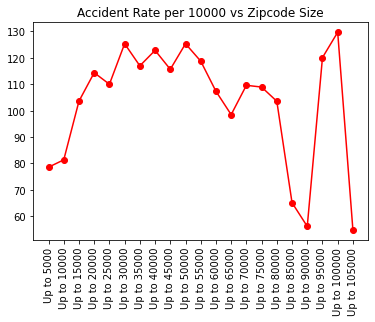

In [14]:
plt.plot(classed_data['Rate'], marker = 'o', color = 'r')
plt.xticks(rotation='vertical')
plt.title('Accident Rate per 10000 vs Zipcode Size')
plt.show()

In [15]:
time_df = accident_data[['Start_Time','City','State','Timezone']]

time_df

,Start_Time,City,State,Timezone
0,2016-02-08 05:46:00,Dayton,OH,US/Eastern
1,2016-02-08 06:07:59,Reynoldsburg,OH,US/Eastern
2,2016-02-08 06:49:27,Williamsburg,OH,US/Eastern
3,2016-02-08 07:23:34,Dayton,OH,US/Eastern
4,2016-02-08 07:39:07,Dayton,OH,US/Eastern
...,...,...,...,...
3513612,2019-08-23 18:03:25,Riverside,CA,US/Pacific
3513613,2019-08-23 19:11:30,San Diego,CA,US/Pacific
3513614,2019-08-23 19:00:21,Orange,CA,US/Pacific
3513615,2019-08-23 19:00:21,Culver City,CA,US/Pacific


## Time of Day

In [16]:
date_time = time_df['Start_Time'][1:30].apply(lambda x: dateutil.parser.parse(x))
date_time.head()

1   2016-02-08 06:07:59
2   2016-02-08 06:49:27
3   2016-02-08 07:23:34
4   2016-02-08 07:39:07
5   2016-02-08 07:44:26
Name: Start_Time, dtype: datetime64[ns]

In [17]:
time_df['Hour'] =time_df['Start_Time'].apply(lambda x: dateutil.parser.parse(x))

<ipython-input-17-87c2e92b3896>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['Hour'] =time_df['Start_Time'].apply(lambda x: dateutil.parser.parse(x))


In [18]:
time_df['Hour'][0:4].apply(lambda timestamp: timestamp.hour)


0    5
1    6
2    6
3    7
Name: Hour, dtype: int64

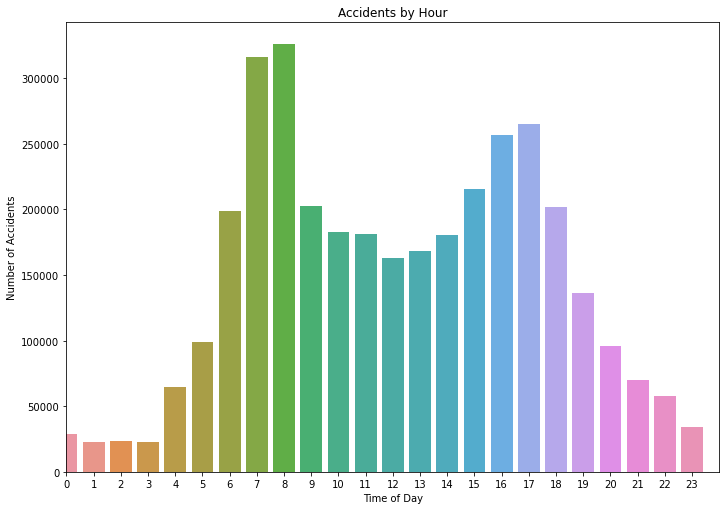

In [19]:
dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=dims)
sns.countplot(x =time_df['Hour'].apply(lambda timestamp: timestamp.hour))
sns.color_palette("coolwarm")
ax.set(xlim=(0,24), xlabel = 'Time of Day', ylabel = 'Number of Accidents', title = 'Accidents by Hour')
plt.savefig('hr.png', dpi=300, bbox_inches='tight')


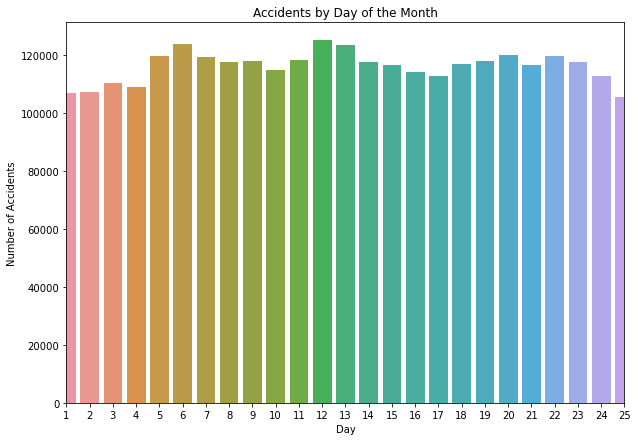

In [20]:
dims = (10, 7)
fig, ax = pyplot.subplots(figsize=dims)
sns.countplot(x=time_df['Hour'].apply(lambda timestamp: timestamp.day))
ax.set(xlim=(0,24), xlabel = 'Day', ylabel = 'Number of Accidents', title = 'Accidents by Day of the Month')
plt.savefig('day.png', dpi=300, bbox_inches='tight')


In [21]:
time_list = time_df['Hour'].apply(lambda timestamp: timestamp.hour).value_counts()
time_list

8     326257
7     316352
17    264893
16    256542
15    215566
9     202664
18    201968
6     198679
10    182608
11    180848
14    180699
13    168260
12    163099
19    136253
5      99244
20     96177
21     69771
4      64706
22     57885
23     33814
0      29109
2      23120
3      22702
1      22401
Name: Hour, dtype: int64

## Weather

In [22]:


#Get total number of accidents

total_accidents = accident_data["ID"].count()

# Extracting ID, Weather Condition and Severity of Accident

wx_df = accident_data[['ID', 'Weather_Condition', 'Severity']]
wx_df = pd.DataFrame(wx_df)
#wx_df = wx_df.fillna(0)


#Group by severity and weather condition to see the number accidents per level of severtiy
wx_group = wx_df.groupby("Severity")["Weather_Condition"]

wx_group_df = pd.DataFrame(wx_group.value_counts())

wx_group_df = wx_group_df.rename(columns={"Weather_Condition": "Number of Accidents"})

#Calculate the number of accidents missing weather data by subtracting the total of t
#in the Number of Accidents Column from the Total Accidents

missing_data = total_accidents - wx_group_df["Number of Accidents"].sum()
missing_percent = round((missing_data / total_accidents) *100, 2)
print(f"There are {missing_data} lines of weather condition data missing")
print(f"This accounts for {missing_percent}% of the total data and is therefore negligble")
wx_group_df

There are 76138 lines of weather condition data missing
This accounts for 2.17% of the total data and is therefore negligble


Number of Accidents
Severity Weather_Condition                                
1        Fair                                        13978
         Mostly Cloudy                                4818
         Cloudy                                       3538
         Partly Cloudy                                2747
         Light Rain                                   1431
...                                                    ...
4        Light Snow with Thunder                         1
         Light Thunderstorms and Snow                    1
         Rain Showers                                    1
         Sand / Dust Whirlwinds                          1
         Squalls                                         1

[363 rows x 1 columns]

In [23]:
#Set variables for total weather conditions and each individual weather condition

total_weather_condition = wx_df["Weather_Condition"].count()
light_rain = wx_df[wx_df["Weather_Condition"] == 'Light Rain']
overcast = wx_df[wx_df["Weather_Condition"] == 'Overcast']
mostly_cloudy = wx_df[wx_df["Weather_Condition"] == 'Mostly Cloudy']
rain = wx_df[wx_df["Weather_Condition"] == 'Rain']
light_snow = wx_df[wx_df["Weather_Condition"] == 'Light Snow']
haze = wx_df[wx_df["Weather_Condition"] == 'Haze']
scattered_clouds = wx_df[wx_df["Weather_Condition"] == 'Scattered Clouds']
partly_cloudy = wx_df[wx_df["Weather_Condition"] == 'Partly Cloudy']
clear = wx_df[wx_df["Weather_Condition"] == 'Clear']
snow = wx_df[wx_df["Weather_Condition"] == 'Snow']
lfd = wx_df[wx_df["Weather_Condition"] == 'Light Freezing Drizzle']
ld = wx_df[wx_df["Weather_Condition"] == 'Light Drizzle']
fog = wx_df[wx_df["Weather_Condition"] == 'Fog']
shallow_fog = wx_df[wx_df["Weather_Condition"] == 'Shallow Fog']
heavy_rain = wx_df[wx_df["Weather_Condition"] == 'Heavy Rain']
lfr = wx_df[wx_df["Weather_Condition"] == 'Light Freezing Rain']
cloudy = wx_df[wx_df["Weather_Condition"] == 'Cloudy']
drizzle = wx_df[wx_df["Weather_Condition"] == 'Drizzle']
lrs = wx_df[wx_df["Weather_Condition"] == 'Light Rain Showers']
mist = wx_df[wx_df["Weather_Condition"] == 'Mist']
smoke = wx_df[wx_df["Weather_Condition"] == 'Smoke']
pof = wx_df[wx_df["Weather_Condition"] == 'Patches of Fog']
lff = wx_df[wx_df["Weather_Condition"] == 'Light Freezing Fog']
light_haze = wx_df[wx_df["Weather_Condition"] == 'Light Haze']
ltr = wx_df[wx_df["Weather_Condition"] == 'Light Thunderstorm and Rain']
hail = wx_df[wx_df["Weather_Condition"] == 'Hail']
sleet = wx_df[wx_df["Weather_Condition"] == 'Sleet']
tornado = wx_df[wx_df["Weather_Condition"] == 'Tornado']
funnel = wx_df[wx_df["Weather_Condition"] == 'Funnel Cloud']
dust = wx_df[wx_df["Weather_Condition"] == 'Dust']
squalls = wx_df[wx_df["Weather_Condition"] == 'Squalls']
windy = wx_df[wx_df["Weather_Condition"] == 'Windy']
thunderstorms = wx_df[wx_df["Weather_Condition"] == 'Thunderstorm']
heavy_rain_showers = wx_df[wx_df["Weather_Condition"] == 'Heavy Rain Showers']
light_ts_rain = wx_df[wx_df["Weather_Condition"] == 'Light Thunderstorms and Rain']
heavy_ts_rain = wx_df[wx_df["Weather_Condition"] == 'Heavy Thunderstorms and Rain']
thunderstorms_rain = wx_df[wx_df["Weather_Condition"] == 'Thunderstorms and Rain']
fair = wx_df[wx_df["Weather_Condition"] == 'Fair']
volcanic_ash = wx_df[wx_df["Weather_Condition"] == 'Volcanic Ash']
blowing_sand = wx_df[wx_df["Weather_Condition"] == 'Blowing Sand']
sand = wx_df[wx_df["Weather_Condition"] == 'Sand']
ice_pellets = wx_df[wx_df["Weather_Condition"] == 'Ice Pellets']
heavy_ice_pellets = wx_df[wx_df["Weather_Condition"] == 'Heavy Ice Pellets']
blowing_snow = wx_df[wx_df["Weather_Condition"] == 'Blowing Snow']
heavy_snow = wx_df[wx_df["Weather_Condition"] == 'Heavy Snow']
heavy_freezing_rain = wx_df[wx_df["Weather_Condition"] == 'Heavy Freezing Rain']
snow_showers = wx_df[wx_df["Weather_Condition"] == 'Snow Showers']
heavy_rain_showers = wx_df[wx_df["Weather_Condition"] == 'Heavy Rain Showers']
snow_sleet = wx_df[wx_df["Weather_Condition"] == 'Snow and Sleet']
sleet = wx_df[wx_df["Weather_Condition"] == 'Sleet']
heavy_sleet = wx_df[wx_df["Weather_Condition"] == 'Heavy Sleet']
light_sleet = wx_df[wx_df["Weather_Condition"] == 'Light Sleet']
heavy_freezing_drizzle = wx_df[wx_df["Weather_Condition"] == 'Heavy Freezing Drizzle']

#Creating a summary table to show the number of accidents for each weather condition

wx_condition_summary = pd.DataFrame({"Total Weather Condition": total_weather_condition,
                               "Light Rain": light_rain.count(),
                               "Overcast": overcast.count(),
                               "Mostly Cloudy": mostly_cloudy.count(),
                               "Rain": rain.count(),
                               "Light Snow": light_snow.count(),
                               "Haze": haze.count(),
                               "Scattered Clouds": scattered_clouds.count(),
                               "Partly Cloudy": partly_cloudy.count(),
                               "Clear Total": clear.count(),
                               "Snow": snow.count(),
                               "Light Freezing Drizzle": lfd.count(),
                               "Light Drizzle": ld.count(),
                               "Fog": fog.count(),
                               "Shallow Fog": shallow_fog.count(),
                               "Heavy Rain": heavy_rain.count(),
                               "Light Freezing Rain": lfr.count(),
                               "Cloudy": cloudy.count(),
                               "Drizzle": drizzle.count(),
                               "Light Rain Showers": lrs.count(),
                               "Mist": mist.count(),
                               "Smoke": smoke.count(),
                               "Patches of Fog": pof.count(),
                               "Light Freezing Fog": lff.count(),
                               "Light Haze": light_haze.count(),
                               "Tornado": tornado.count(),
                               "Funnel": funnel.count(),
                               "Dust": dust.count(),
                               "Squalls": squalls.count(),
                               "Windy": windy.count(),
                               "Thunderstorms": thunderstorms.count(),
                               "Hail": hail.count(),
                               "Sleet": sleet.count(),
                               "Dust": dust.count(),
                               "Squalls": squalls.count(),
                               "Windy": windy.count(),
                               "Thunderstorms": thunderstorms.count(),
                               "Heavy Rain Showers": heavy_rain_showers.count(),
                               "Light Thunderstorms and Rain": light_ts_rain.count(),
                               "Heavy Thunderstorms and Rain": heavy_ts_rain.count(),
                               "Thunderstorms and Rain": thunderstorms_rain.count(),
                               "Fair": fair.count(),
                               "Volcanic Ash": volcanic_ash.count(),
                               "Blowing Sand": blowing_sand.count(),
                               "Sand": sand.count(),
                               "Ice Pellets": ice_pellets.count(),
                               "Heavy Ice Pellets": heavy_ice_pellets.count(),
                               "Blowing Snow": blowing_snow.count(),
                               "Heavy Snow": heavy_snow.count(),
                               "Heavy Freezing Rain": heavy_freezing_rain.count(),
                               "Snow Showers": snow_showers.count(),
                               "Heavy Rain Showers": heavy_rain_showers.count(),
                               "Snow and Sleet": snow_sleet.count(),
                               "Sleet": sleet.count(),
                               "Heavy Sleet": heavy_sleet.count(),
                               "Light Sleet": light_sleet.count(),
                               "Heavy Freezing Drizzle": heavy_freezing_drizzle.count()})
            


#Dropping a few rows    

wx_condition_summary = wx_condition_summary.drop("Severity")
wx_condition_summary = wx_condition_summary.drop("ID")


wx_condition_summary



,Total Weather Condition,Light Rain,Overcast,Mostly Cloudy,Rain,Light Snow,Haze,Scattered Clouds,Partly Cloudy,Clear Total,...,Ice Pellets,Heavy Ice Pellets,Blowing Snow,Heavy Snow,Heavy Freezing Rain,Snow Showers,Snow and Sleet,Heavy Sleet,Light Sleet,Heavy Freezing Drizzle
Weather_Condition,3437479,176942,382485,488094,42016,50435,38699,204660,344815,808202,...,101,4,337,1507,2,2,18,6,19,2


In [24]:
#Create variables of conditions using str.contains. 
#For example all rainy conditions will be grouped into one variable if the Column Name 
#contains "Rain"



rainy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Rain')].sum()
snowy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Snow')].sum()
clear_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Clear')].sum()
foggy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Fog')].sum()
clear_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Clear')].sum()
misty_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Mist')].sum()
cloudy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Cloud')].sum()
freezing_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Freez')].sum()
smokey_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Smok')].sum()
drizzle_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Drizzle')].sum()
hazy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Haze')].sum()
thunder_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Thunder')].sum()
overcast_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Overcast')].sum()
dusty_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Dust')].sum()
tornado = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Tornado')].sum()
funnel = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Funnel')].sum()
sandy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Sand')].sum()
windy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Wind')].sum()
ash_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Ash')].sum()
fair_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Fair')].sum()
sleet_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Sleet')].sum()
icy_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Ice')].sum()
squall_conditions = wx_condition_summary.loc[:, wx_condition_summary.columns.str.contains('Squalls')].sum()


In [25]:
#Create functions to make various calculations

#Average accidents by condition (using condition variables above)

def accident_condition(condition):
    avg_accident = round((condition / total_accidents) * 100, 2)
    #return avg_accident
    print(avg_accident.map("%{:,.2f}".format))

#Making a value judgment and deciding on the worst conidtions and putting them into a function to calculate
# with total number of non ideal conditions

def non_ideal():
    non_ideal = snowy_conditions.sum() + foggy_conditions.sum() + rainy_conditions.sum() + \
    misty_conditions.sum() + freezing_conditions.sum() + smokey_conditions.sum() + hazy_conditions.sum() + \
    drizzle_conditions.sum() + dusty_conditions.sum() + tornado.sum() + funnel.sum() + \
    sandy_conditions.sum() + windy_conditions.sum() + ash_conditions.sum() + \
    sleet_conditions.sum() + icy_conditions.sum() + thunder_conditions.sum() + \
    squall_conditions.sum()
    return non_ideal

#Function for totalling all cloudy conditions

def cloudy():
    cloudy = cloudy_conditions.sum() + overcast_conditions.sum()
    return cloudy


#Function for totalling clear conditions
def clear_fair():
    clear_fair = clear_conditions.sum() + fair_conditions.sum()
    return clear_fair


# #messing around with putting it into an array
# def non_ideal_1():
#     non_ideal_1 = [snowy_conditions.sum(), foggy_conditions.sum(), rainy_conditions.sum(),
#     misty_conditions.sum(), cloudy_conditions.sum(), freezing_conditions.sum()]
    
#     return non_ideal_1

#Average of the various conditions (using the functions)

def average_condition_total(function):
    percent = round(function / total_accidents * 100, 2)
    print(f"{percent}% of accidents occur in those conditions")



In [26]:
#Example 1 using rainy_conditions
accident_condition(rainy_conditions)

Light Rain                      %5.04
Rain                            %1.20
Heavy Rain                      %0.44
Light Freezing Rain             %0.06
Light Rain Showers              %0.00
Heavy Rain Showers              %0.00
Light Thunderstorms and Rain    %0.14
Heavy Thunderstorms and Rain    %0.07
Thunderstorms and Rain          %0.06
Heavy Freezing Rain             %0.00
dtype: object


In [27]:
## Majority of Accidents occur in Cloudy Conditions

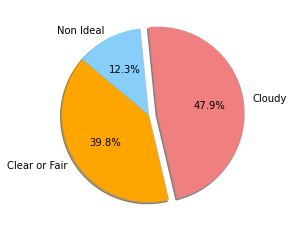

In [28]:
#Create a pie chart to visualize the percentage of accidents in three different weather conditions:
#Clear, Cloudy, Non Ideal

x_labels = ["Clear or Fair", "Cloudy", "Non Ideal"]
y_labels = [clear_fair(), cloudy(), non_ideal()]
explode = [0.0, 0.1, 0]
colors = ["orange", "lightcoral", "lightskyblue"]

plt.pie(y_labels, explode=explode, labels=x_labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.savefig("Images/wx_breakdown.png")

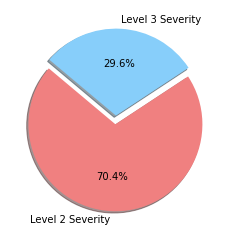

In [29]:
level_1 = wx_df[wx_df["Severity"] == 1]
level_2 = wx_df[wx_df["Severity"] == 2]
level_3 = wx_df[wx_df["Severity"] == 3]
level_4 = wx_df[wx_df["Severity"] == 4]

x_labels_severe = ["Level 2 Severity", "Level 3 Severity"]
y_labels_severe = [level_2["Severity"].count(), level_3["Severity"].count()]
explode_severe = [0.1, 0]
colors_severe = ["lightcoral", "lightskyblue"]

plt.pie(y_labels_severe, explode=explode_severe, labels=x_labels_severe, colors=colors_severe,
        autopct="%1.1f%%", shadow=True, startangle=140)

plt.savefig("Images/severity_breakdown.png")

## Bar Proximity

In [30]:
bar_df = pd.read_csv("US_Accidents_June20.csv")
bar_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201,3,2/8/2016 5:46,2/8/2016 11:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201,2,2/8/2016 6:07,2/8/2016 6:37,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201,2,2/8/2016 6:49,2/8/2016 7:19,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201,3,2/8/2016 7:23,2/8/2016 7:53,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201,2,2/8/2016 7:39,2/8/2016 8:09,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [31]:
bar_data = bar_df[['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Zipcode', 'State',]]
bar_data.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State
0,A-1,3,2/8/2016 5:46,2/8/2016 11:00,39.865147,-84.058723,45424,OH
1,A-2,2,2/8/2016 6:07,2/8/2016 6:37,39.928059,-82.831184,43068-3402,OH
2,A-3,2,2/8/2016 6:49,2/8/2016 7:19,39.063148,-84.032608,45176,OH
3,A-4,3,2/8/2016 7:23,2/8/2016 7:53,39.747753,-84.205582,45417,OH
4,A-5,2,2/8/2016 7:39,2/8/2016 8:09,39.627781,-84.188354,45459,OH


In [32]:
random_zip = bar_data.loc[bar_data["Zipcode"] == "94551",:]
random_zip


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State
737,A-738,3,6/21/2016 10:57,6/21/2016 11:27,37.700951,-121.801750,94551,CA
740,A-741,3,6/21/2016 11:11,6/21/2016 11:41,37.700714,-121.773895,94551,CA
757,A-758,3,6/21/2016 12:13,6/21/2016 12:43,37.700714,-121.773895,94551,CA
811,A-812,3,6/21/2016 20:19,6/21/2016 20:49,37.700043,-121.779655,94551,CA
843,A-844,3,6/22/2016 9:12,6/22/2016 9:42,37.708939,-121.723686,94551,CA
...,...,...,...,...,...,...,...,...
10600,A-10601,2,1/10/2017 13:05,1/10/2017 13:35,37.730579,-121.733620,94551,CA
10854,A-10855,3,1/12/2017 9:00,1/12/2017 9:30,37.701157,-121.823715,94551,CA
10857,A-10858,3,1/12/2017 9:06,1/12/2017 9:35,37.700363,-121.791862,94551,CA
11034,A-11035,3,1/13/2017 14:33,1/13/2017 15:02,37.700714,-121.773895,94551,CA


In [33]:
mode = bar_data["Zipcode"].mode()
mode

0    94551
dtype: object

In [34]:
target_city = "Livermore, California"

# Build the endpoint URL
target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
    'address={0}&key={1}').format(target_city, gkey)
geo_data = requests.get(target_url).json()

# Print the json

lat = geo_data["results"][0]["geometry"]["location"]["lat"]
lng = geo_data["results"][0]["geometry"]["location"]["lng"]

# Print the latitude and longitude
print('''
    City: {0}
    Latitude: {1}
    Longitude: {2}
    '''.format(target_city, lat, lng))


    City: Livermore, California
    Latitude: 37.6818688
    Longitude: -121.7684732
    


In [35]:
params = {
    "radius": 50000,
    "types": "bar",
    "key": gkey
}


for index, row in random_zip.iterrows():
    # get lat, lng from df
    lat = row["Start_Lat"]
    lng = row["Start_Lng"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    

    # convert to json
    name_address = name_address.json()
    # print(json.dumps(name_address, indent=4, sort_keys=True))

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        random_zip.loc[index, "Bars Near Crash"] = name_address["results"][0]["name"]
       
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
random_zip

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State,Bars Near Crash
737,A-738,3,6/21/2016 10:57,6/21/2016 11:27,37.700951,-121.801750,94551,CA,Hotel Shattuck Plaza
740,A-741,3,6/21/2016 11:11,6/21/2016 11:41,37.700714,-121.773895,94551,CA,Hotel Shattuck Plaza
757,A-758,3,6/21/2016 12:13,6/21/2016 12:43,37.700714,-121.773895,94551,CA,Hotel Shattuck Plaza
811,A-812,3,6/21/2016 20:19,6/21/2016 20:49,37.700043,-121.779655,94551,CA,Hotel Shattuck Plaza
843,A-844,3,6/22/2016 9:12,6/22/2016 9:42,37.708939,-121.723686,94551,CA,Texas Roadhouse
...,...,...,...,...,...,...,...,...,...
10600,A-10601,2,1/10/2017 13:05,1/10/2017 13:35,37.730579,-121.733620,94551,CA,Hotel Shattuck Plaza
10854,A-10855,3,1/12/2017 9:00,1/12/2017 9:30,37.701157,-121.823715,94551,CA,Hotel Shattuck Plaza
10857,A-10858,3,1/12/2017 9:06,1/12/2017 9:35,37.700363,-121.791862,94551,CA,Hotel Shattuck Plaza
11034,A-11035,3,1/13/2017 14:33,1/13/2017 15:02,37.700714,-121.773895,94551,CA,Hotel Shattuck Plaza


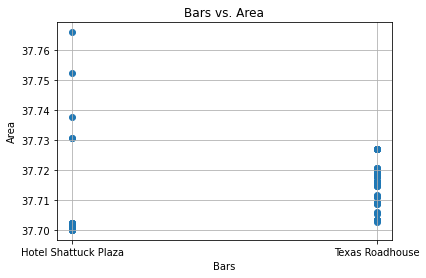

<Figure size 432x288 with 0 Axes>

In [37]:
# Plot scatter plot
plt.scatter(random_zip['Bars Near Crash'],random_zip['Start_Lat'])

# Plot regression line



# Label plot
plt.title('Bars vs. Area')
plt.xlabel('Bars')
plt.ylabel('Area')
plt.grid()

# Print r square value


# Show plot
plt.show()
plt.savefig("Bar1chart")

<BarContainer object of 2471 artists>

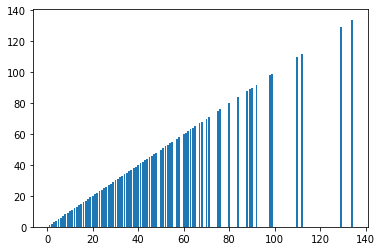

In [38]:
zip_group = bar_data.groupby('Zipcode')

# Count how many times each maker appears in our group
zip_code = zip_group['Zipcode'].count()

zip_code

plt.bar(zip_code,zip_code)

In [39]:
items_counts = bar_data['Zipcode'].value_counts()
items_counts

94551         134
94607         129
95304         112
94588         110
95823          99
             ... 
45405-2406      1
45106-9354      1
94583-1906      1
95451-7825      1
95456           1
Name: Zipcode, Length: 2471, dtype: int64

In [40]:
random_zip2 = bar_data.loc[bar_data["Zipcode"] == "94607",:]
random_zip2


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State
770,A-771,3,6/21/2016 13:02,6/21/2016 13:32,37.825397,-122.304802,94607,CA
856,A-857,3,6/22/2016 10:33,6/22/2016 11:03,37.798454,-122.274803,94607,CA
893,A-894,3,6/22/2016 12:56,6/22/2016 13:26,37.795124,-122.266594,94607,CA
896,A-897,3,6/22/2016 13:05,6/22/2016 13:35,37.793484,-122.263992,94607,CA
1022,A-1023,3,6/23/2016 12:05,6/23/2016 12:35,37.825237,-122.305832,94607,CA
...,...,...,...,...,...,...,...,...
10728,A-10729,3,1/11/2017 4:46,1/11/2017 5:30,37.828934,-122.293770,94607,CA
10843,A-10844,3,1/12/2017 5:53,1/12/2017 6:29,37.827106,-122.296150,94607,CA
11078,A-11079,3,1/13/2017 19:59,1/13/2017 20:29,37.823292,-122.316734,94607,CA
11245,A-11246,3,1/15/2017 20:50,1/15/2017 21:20,37.807938,-122.304504,94607,CA


In [41]:
params = {
    "radius": 50000,
    "types": "bar",
    "key": gkey
}


for index, row in random_zip2.iterrows():
    # get lat, lng from df
    lat = row["Start_Lat"]
    lng = row["Start_Lng"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    

    # convert to json
    name_address = name_address.json()
    # print(json.dumps(name_address, indent=4, sort_keys=True))

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        random_zip2.loc[index, "Bars Near Crash"] = name_address["results"][0]["name"]
       
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [42]:
random_zip3 = bar_data.loc[bar_data["Zipcode"] == "95304",:]
random_zip3


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State
810,A-811,3,6/21/2016 20:03,6/21/2016 20:48,37.766987,-121.335495,95304,CA
946,A-947,2,6/22/2016 20:20,6/22/2016 21:05,37.638012,-121.324409,95304,CA
960,A-961,1,6/22/2016 23:54,6/23/2016 0:39,37.750488,-121.379982,95304,CA
1061,A-1062,3,6/23/2016 17:51,6/23/2016 18:51,37.763535,-121.418747,95304,CA
1187,A-1188,3,6/24/2016 21:45,6/24/2016 22:45,37.592789,-121.335754,95304,CA
...,...,...,...,...,...,...,...,...
10949,A-10950,3,1/12/2017 22:48,1/12/2017 23:18,37.764702,-121.409195,95304,CA
11081,A-11082,3,1/13/2017 20:07,1/13/2017 20:36,37.740891,-121.505043,95304,CA
11082,A-11083,3,1/13/2017 20:26,1/13/2017 20:56,37.764755,-121.390137,95304,CA
11230,A-11231,3,1/15/2017 16:05,1/15/2017 16:50,37.762814,-121.431549,95304,CA


In [43]:
params = {
    "radius": 50000,
    "types": "bar",
    "key": gkey
}


for index, row in random_zip3.iterrows():
    # get lat, lng from df
    lat = row["Start_Lat"]
    lng = row["Start_Lng"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    

    # convert to json
    name_address = name_address.json()
    # print(json.dumps(name_address, indent=4, sort_keys=True))

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        random_zip3.loc[index, "Bars Near Crash"] = name_address["results"][0]["name"]
       
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [44]:
random_zip3

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State,Bars Near Crash
810,A-811,3,6/21/2016 20:03,6/21/2016 20:48,37.766987,-121.335495,95304,CA,Quality Inn Modesto - Salida
946,A-947,2,6/22/2016 20:20,6/22/2016 21:05,37.638012,-121.324409,95304,CA,Quality Inn Modesto - Salida
960,A-961,1,6/22/2016 23:54,6/23/2016 0:39,37.750488,-121.379982,95304,CA,Quality Inn Modesto - Salida
1061,A-1062,3,6/23/2016 17:51,6/23/2016 18:51,37.763535,-121.418747,95304,CA,Quality Inn Modesto - Salida
1187,A-1188,3,6/24/2016 21:45,6/24/2016 22:45,37.592789,-121.335754,95304,CA,Quality Inn Modesto - Salida
...,...,...,...,...,...,...,...,...,...
10949,A-10950,3,1/12/2017 22:48,1/12/2017 23:18,37.764702,-121.409195,95304,CA,Quality Inn Modesto - Salida
11081,A-11082,3,1/13/2017 20:07,1/13/2017 20:36,37.740891,-121.505043,95304,CA,Quality Inn Modesto - Salida
11082,A-11083,3,1/13/2017 20:26,1/13/2017 20:56,37.764755,-121.390137,95304,CA,Quality Inn Modesto - Salida
11230,A-11231,3,1/15/2017 16:05,1/15/2017 16:50,37.762814,-121.431549,95304,CA,Quality Inn Modesto - Salida


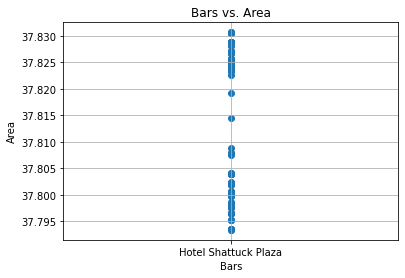

<Figure size 432x288 with 0 Axes>

In [45]:
# Plot scatter plot
plt.scatter(random_zip2['Bars Near Crash'],random_zip2['Start_Lat'])

# Plot regression line



# Label plot
plt.title('Bars vs. Area')
plt.xlabel('Bars')
plt.ylabel('Area')
plt.grid()

# Print r square value


# Show plot
plt.show()
plt.savefig("Bar3chart")

In [46]:
random_zip4 = bar_data.loc[bar_data["Zipcode"] == "94588",:]
random_zip4

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State
733,A-734,3,6/21/2016 10:31,6/21/2016 11:16,37.701584,-121.906929,94588,CA
749,A-750,3,6/21/2016 11:34,6/21/2016 12:04,37.701363,-121.849533,94588,CA
807,A-808,3,6/21/2016 19:46,6/21/2016 20:16,37.701649,-121.911278,94588,CA
965,A-966,3,6/23/2016 2:30,6/23/2016 3:30,37.690514,-121.918709,94588,CA
1000,A-1001,3,6/23/2016 10:42,6/23/2016 11:12,37.701363,-121.849533,94588,CA
...,...,...,...,...,...,...,...,...
11080,A-11081,3,1/13/2017 20:15,1/13/2017 20:45,37.700935,-121.922119,94588,CA
11125,A-11126,3,1/14/2017 5:29,1/14/2017 6:13,37.700802,-121.922760,94588,CA
11139,A-11140,3,1/14/2017 10:36,1/14/2017 11:05,37.701603,-121.874664,94588,CA
11251,A-11252,3,1/15/2017 21:44,1/15/2017 22:13,37.701405,-121.888115,94588,CA


In [47]:
params = {
    "radius": 50000,
    "types": "bar",
    "key": gkey
}


for index, row in random_zip4.iterrows():
    # get lat, lng from df
    lat = row["Start_Lat"]
    lng = row["Start_Lng"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    

    # convert to json
    name_address = name_address.json()
    # print(json.dumps(name_address, indent=4, sort_keys=True))

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        random_zip4.loc[index, "Bars Near Crash"] = name_address["results"][0]["name"]
       
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [48]:
random_zip4

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State,Bars Near Crash
733,A-734,3,6/21/2016 10:31,6/21/2016 11:16,37.701584,-121.906929,94588,CA,Hotel Shattuck Plaza
749,A-750,3,6/21/2016 11:34,6/21/2016 12:04,37.701363,-121.849533,94588,CA,Hotel Shattuck Plaza
807,A-808,3,6/21/2016 19:46,6/21/2016 20:16,37.701649,-121.911278,94588,CA,Hotel Shattuck Plaza
965,A-966,3,6/23/2016 2:30,6/23/2016 3:30,37.690514,-121.918709,94588,CA,Hotel Shattuck Plaza
1000,A-1001,3,6/23/2016 10:42,6/23/2016 11:12,37.701363,-121.849533,94588,CA,Hotel Shattuck Plaza
...,...,...,...,...,...,...,...,...,...
11080,A-11081,3,1/13/2017 20:15,1/13/2017 20:45,37.700935,-121.922119,94588,CA,Hotel Shattuck Plaza
11125,A-11126,3,1/14/2017 5:29,1/14/2017 6:13,37.700802,-121.922760,94588,CA,Hotel Shattuck Plaza
11139,A-11140,3,1/14/2017 10:36,1/14/2017 11:05,37.701603,-121.874664,94588,CA,Hotel Shattuck Plaza
11251,A-11252,3,1/15/2017 21:44,1/15/2017 22:13,37.701405,-121.888115,94588,CA,Hotel Shattuck Plaza


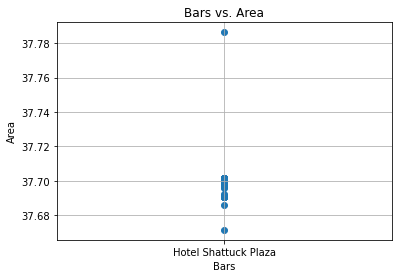

<Figure size 432x288 with 0 Axes>

In [49]:
plt.scatter(random_zip4['Bars Near Crash'],random_zip4['Start_Lat'])

# Plot regression line



# Label plot
plt.title('Bars vs. Area')
plt.xlabel('Bars')
plt.ylabel('Area')
plt.grid()

# Print r square value


# Show plot
plt.show()
plt.savefig("Bar4chart")

In [50]:
random_zip5 = bar_data.loc[bar_data["Zipcode"] == "95823",:]
random_zip5

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State
876,A-877,2,6/22/2016 11:19,6/22/2016 12:04,38.510151,-121.459702,95823,CA
898,A-899,2,6/22/2016 13:19,6/22/2016 14:04,38.478897,-121.421066,95823,CA
1008,A-1009,2,6/23/2016 10:54,6/23/2016 12:09,38.510448,-121.460121,95823,CA
1106,A-1107,2,6/24/2016 10:14,6/24/2016 10:59,38.496033,-121.446091,95823,CA
1475,A-1476,2,6/27/2016 20:29,6/27/2016 21:59,38.500240,-121.435188,95823,CA
...,...,...,...,...,...,...,...,...
11021,A-11022,2,1/13/2017 12:36,1/13/2017 13:05,38.469612,-121.418022,95823,CA
11054,A-11055,2,1/13/2017 18:21,1/13/2017 18:51,38.493591,-121.457993,95823,CA
11071,A-11072,2,1/13/2017 19:28,1/13/2017 19:57,38.495804,-121.445557,95823,CA
11321,A-11322,2,1/16/2017 17:03,1/16/2017 17:47,38.474407,-121.419067,95823,CA


In [51]:
params = {
    "radius": 50000,
    "types": "bar",
    "key": gkey
}


for index, row in random_zip5.iterrows():
    # get lat, lng from df
    lat = row["Start_Lat"]
    lng = row["Start_Lng"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_address = requests.get(base_url, params=params)
    

    # convert to json
    name_address = name_address.json()
    # print(json.dumps(name_address, indent=4, sort_keys=True))

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        random_zip5.loc[index, "Bars Near Crash"] = name_address["results"][0]["name"]
       
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [52]:
random_zip5

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Zipcode,State,Bars Near Crash
876,A-877,2,6/22/2016 11:19,6/22/2016 12:04,38.510151,-121.459702,95823,CA,BJ's Restaurant & Brewhouse
898,A-899,2,6/22/2016 13:19,6/22/2016 14:04,38.478897,-121.421066,95823,CA,BJ's Restaurant & Brewhouse
1008,A-1009,2,6/23/2016 10:54,6/23/2016 12:09,38.510448,-121.460121,95823,CA,BJ's Restaurant & Brewhouse
1106,A-1107,2,6/24/2016 10:14,6/24/2016 10:59,38.496033,-121.446091,95823,CA,BJ's Restaurant & Brewhouse
1475,A-1476,2,6/27/2016 20:29,6/27/2016 21:59,38.500240,-121.435188,95823,CA,BJ's Restaurant & Brewhouse
...,...,...,...,...,...,...,...,...,...
11021,A-11022,2,1/13/2017 12:36,1/13/2017 13:05,38.469612,-121.418022,95823,CA,BJ's Restaurant & Brewhouse
11054,A-11055,2,1/13/2017 18:21,1/13/2017 18:51,38.493591,-121.457993,95823,CA,BJ's Restaurant & Brewhouse
11071,A-11072,2,1/13/2017 19:28,1/13/2017 19:57,38.495804,-121.445557,95823,CA,BJ's Restaurant & Brewhouse
11321,A-11322,2,1/16/2017 17:03,1/16/2017 17:47,38.474407,-121.419067,95823,CA,BJ's Restaurant & Brewhouse


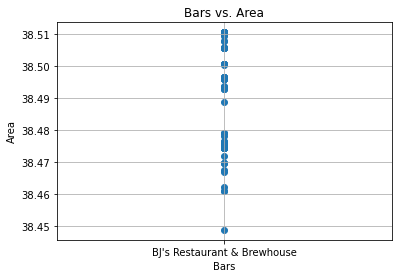

<Figure size 432x288 with 0 Axes>

In [53]:
plt.scatter(random_zip5['Bars Near Crash'],random_zip5['Start_Lat'])

# Plot regression line



# Label plot
plt.title('Bars vs. Area')
plt.xlabel('Bars')
plt.ylabel('Area')
plt.grid()

# Print r square value


# Show plot
plt.show()
plt.savefig("Bar5chart")

## Holidays

In [54]:
location="Resources/US_Accidents_June20.csv"
df=pd.read_csv(location)
df.head(5)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201,3,2/8/2016 5:46,2/8/2016 11:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201,2,2/8/2016 6:07,2/8/2016 6:37,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201,2,2/8/2016 6:49,2/8/2016 7:19,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201,3,2/8/2016 7:23,2/8/2016 7:53,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201,2,2/8/2016 7:39,2/8/2016 8:09,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [55]:
df["Day_Number"]=""
df["Holiday"]=""

df[['Date','Time']] = df.Start_Time.str.split(expand=True)
df["Time"]=pd.to_datetime(df["Time"], format='%H:%M').dt.hour

bins=[0,5.9,10.9,15.9,19.9,23.9]
period=["Midnight","Morning","Afternoon","Evening","Night"]
df["Day_Period"] = pd.cut(df["Time"], bins, labels=period, include_lowest=True)

In [56]:
delete_column_list=['Source', 'TMC','Start_Time','End_Time', 'End_Lat', 'End_Lng','Distance(mi)','Description', 'Number','Side',
                    'Timezone', 'Airport_Code','Weather_Timestamp','Wind_Chill(F)','Pressure(in)',
                    'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Precipitation(in)','Amenity', 
                    'Bump', 'Crossing','Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
                    'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Sunrise_Sunset', 'Civil_Twilight', 
                    'Nautical_Twilight','Astronomical_Twilight']
for column in delete_column_list:
    del df[column]
    
df.head(5)    

,ID,Severity,Start_Lat,Start_Lng,Street,City,County,State,Zipcode,Country,Temperature(F),Humidity(%),Weather_Condition,Day_Number,Holiday,Date,Time,Day_Period
0,A-1,3,39.865147,-84.058723,I-70 E,Dayton,Montgomery,OH,45424,US,36.9,91.0,Light Rain,,,2/8/2016,5,Midnight
1,A-2,2,39.928059,-82.831184,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,37.9,100.0,Light Rain,,,2/8/2016,6,Morning
2,A-3,2,39.063148,-84.032608,State Route 32,Williamsburg,Clermont,OH,45176,US,36.0,100.0,Overcast,,,2/8/2016,6,Morning
3,A-4,3,39.747753,-84.205582,I-75 S,Dayton,Montgomery,OH,45417,US,35.1,96.0,Mostly Cloudy,,,2/8/2016,7,Morning
4,A-5,2,39.627781,-84.188354,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,36.0,89.0,Mostly Cloudy,,,2/8/2016,7,Morning


In [58]:
df=df.rename(columns={
    "Start_Lat":"Latitude",
    "Start_Lng":"Longtitude",
    "Temperature(F)":"Temperature"
})
# df=pd.merge(df,calender_df,on="Date",how='inner')

In [59]:
accident_df=df[["ID","Date","Day_Period","Time","Holiday","Day_Number","Severity","Street","City","County","State",
                "Zipcode","Latitude","Longtitude","Weather_Condition","Temperature"]]

accident_df.head(5)


,ID,Date,Day_Period,Time,Holiday,Day_Number,Severity,Street,City,County,State,Zipcode,Latitude,Longtitude,Weather_Condition,Temperature
0,A-1,2/8/2016,Midnight,5,,,3,I-70 E,Dayton,Montgomery,OH,45424,39.865147,-84.058723,Light Rain,36.9
1,A-2,2/8/2016,Morning,6,,,2,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,39.928059,-82.831184,Light Rain,37.9
2,A-3,2/8/2016,Morning,6,,,2,State Route 32,Williamsburg,Clermont,OH,45176,39.063148,-84.032608,Overcast,36.0
3,A-4,2/8/2016,Morning,7,,,3,I-75 S,Dayton,Montgomery,OH,45417,39.747753,-84.205582,Mostly Cloudy,35.1
4,A-5,2/8/2016,Morning,7,,,2,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,39.627781,-84.188354,Mostly Cloudy,36.0


In [60]:
accident_df.loc[accident_df["Date"]=="7/2/2016",["Day_Number"]]="1st_Day"
accident_df.loc[accident_df["Date"]=="7/3/2016",["Day_Number"]]="2nd_Day"
accident_df.loc[accident_df["Date"]=="7/4/2016",["Day_Number"]]="3rd_Day"
accident_df.loc[accident_df["Date"]=="7/5/2016",["Day_Number"]]="4th_Day"

accident_df.loc[(accident_df["Date"]=="7/2/2016")|(accident_df["Date"]=="7/3/2016")|
                (accident_df["Date"]=="7/4/2016")|(accident_df["Date"]=="7/5/2016"),
           "Holiday"]="Independence_Day"

independence_df=accident_df.loc[accident_df["Holiday"]=="Independence_Day",
                                ["ID","Holiday","Day_Number","Day_Period","Severity",
                                 "Latitude","Longtitude","Street","City","Zipcode",
                                 "State","Date","Time","Weather_Condition","Temperature"]]

independence_df

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ID,Holiday,Day_Number,Day_Period,Severity,Latitude,Longtitude,Street,City,Zipcode,State,Date,Time,Weather_Condition,Temperature
1906,A-1907,Independence_Day,1st_Day,Morning,2,37.840397,-122.023911,Danville Blvd,Alamo,94507-2106,CA,7/2/2016,9,Clear,73.0
1907,A-1908,Independence_Day,1st_Day,Morning,3,37.708939,-121.723686,I-580 E,Livermore,94551,CA,7/2/2016,9,Clear,73.0
1908,A-1909,Independence_Day,1st_Day,Morning,2,37.743294,-121.343498,I-5 N,Tracy,95304,CA,7/2/2016,7,Clear,68.0
1909,A-1910,Independence_Day,1st_Day,Morning,2,38.021015,-121.329979,W Hammer Ln,Stockton,95209-3013,CA,7/2/2016,10,Clear,81.0
1910,A-1911,Independence_Day,1st_Day,Morning,2,37.821934,-121.291641,I-5 N,Lathrop,95330,CA,7/2/2016,10,Clear,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,A-2215,Independence_Day,4th_Day,Night,3,37.987347,-121.344704,I-5 S,Stockton,95219,CA,7/5/2016,22,Clear,66.0
2215,A-2216,Independence_Day,4th_Day,Night,2,38.529095,-121.470215,26th Ave,Sacramento,95820,CA,7/5/2016,23,Clear,57.9
2216,A-2217,Independence_Day,4th_Day,Night,2,39.447063,-123.385353,Lupine Dr,Willits,95490-8035,CA,7/5/2016,23,Clear,66.0
2217,A-2218,Independence_Day,4th_Day,Night,2,37.807072,-122.475616,Golden Gate Brg S,San Francisco,94129,CA,7/5/2016,23,Partly Cloudy,57.0


In [61]:
accident_df.loc[accident_df["Date"]=="12/23/2016",["Day_Number"]]="1st_Day"
accident_df.loc[accident_df["Date"]=="12/24/2016",["Day_Number"]]="2nd_Day"
accident_df.loc[accident_df["Date"]=="12/25/2016",["Day_Number"]]="3rd_Day"
accident_df.loc[accident_df["Date"]=="12/26/2016",["Day_Number"]]="4th_Day" 

accident_df.loc[(accident_df["Date"]=="12/23/2016")|(accident_df["Date"]=="12/24/2016")|
                (accident_df["Date"]=="12/25/2016")|(accident_df["Date"]=="12/26/2016"),"Holiday"]="Christmast"

christmast_df=accident_df.loc[accident_df["Holiday"]=="Christmast",
                                ["ID","Holiday","Day_Number","Day_Period","Severity",
                                 "Latitude","Longtitude","Street","City","Zipcode",
                                 "State","Date","Time","Weather_Condition","Temperature"]]
christmast_df.to_csv("Resources/christmast.csv", index=False, header=True)
christmast_df

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ID,Holiday,Day_Number,Day_Period,Severity,Latitude,Longtitude,Street,City,Zipcode,State,Date,Time,Weather_Condition,Temperature
8274,A-8275,Christmast,1st_Day,Midnight,3,37.604694,-121.342896,I-5 S,Tracy,95304,CA,12/23/2016,0,Clear,45.0
8275,A-8276,Christmast,1st_Day,Midnight,3,37.582081,-121.322411,Westside Fwy S,Patterson,95363,CA,12/23/2016,0,Clear,42.1
8276,A-8277,Christmast,1st_Day,Midnight,3,38.240532,-122.090614,I-80 E,Fairfield,94534,CA,12/23/2016,0,Mostly Cloudy,44.1
8277,A-8278,Christmast,1st_Day,Midnight,3,38.575710,-121.508430,I-5 S,Sacramento,95814,CA,12/23/2016,0,Clear,46.9
8278,A-8279,Christmast,1st_Day,Midnight,3,37.546234,-122.022675,Nimitz Fwy S,Newark,94560,CA,12/23/2016,1,Rain,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8655,A-8656,Christmast,4th_Day,Night,3,37.770020,-121.328255,I-205 W,Tracy,95304,CA,12/26/2016,22,Clear,33.1
8656,A-8657,Christmast,4th_Day,Night,2,37.773006,-121.177032,CA-99 N,Ripon,95366,CA,12/26/2016,22,Clear,39.0
8657,A-8658,Christmast,4th_Day,Night,2,38.505619,-121.455971,CA-99 N,Sacramento,95823,CA,12/26/2016,22,Clear,34.0
8658,A-8659,Christmast,4th_Day,Night,2,37.056732,-120.975060,Highway 152,Los Banos,93635,CA,12/26/2016,22,Clear,33.1


In [62]:
def accident_day_periods(holiday_df,nth_Day):
    m=holiday_df.loc[holiday_df["Day_Number"]==nth_Day,
                                        ["Day_Number","Day_Period"]].groupby(["Day_Period"]).count()
    m=m.reset_index(drop=False)
    m=m.rename(columns={
        "Day_Period":"Time",
        "Day_Number":"Total Accident"})
    
    p=m["Time"].tolist()
    c=m["Total Accident"].tolist()
    t=[]
    periods=["Midnight","Morning","Afternoon","Evening","Night"]
    
    for i in periods:
        if i in p:
            index=p.index(i)
            t.append(c[index])
        else:
            t.append(0)
    return t

In [63]:
def create_dataframe(list1,list2,list3,list4):
    day_list=[]
    day_list.append(list1)
    day_list.append(list2)
    day_list.append(list3)
    day_list.append(list4)
    periods=["Midnight","Morning","Afternoon","Evening","Night"]
    df = pd.DataFrame(day_list, columns =periods, dtype = float)
    df["Days"]=["1st_Day","2nd_Day","3rd_Day","4th_Days"]
    df["Total"]=df["Midnight"]+df["Morning"]+df["Afternoon"]+df["Evening"]+df["Night"]
    df=df[["Days","Midnight","Morning","Afternoon","Evening","Night","Total"]]
    
    return df

In [64]:
def plot_holiday_periods(day1,day2,day3,day4):
    periods=["Midnight","Morning","Afternoon","Evening","Night"]
    plt.bar([a for a in periods], day1, width= -0.25, label = '1st Day', align='edge')
    plt.bar([a for a in periods], day2, width= -0.10, label = '2nd Day', align='edge')
    plt.bar([a for a in periods], day3, width= 0.25, label = '3rd Day', align='edge')
    plt.bar([a for a in periods], day4, width= 0.10, label = '4th Day', align='edge')
    
    plt.title('Accident')
    plt.xlabel('Day Periods')
    plt.ylabel('Accident Numbers')
    plt.legend(loc='upper right')
    plt.xticks(periods)
    plt.grid(True, linewidth= 1, linestyle="--")
    
    return plt.show()

In [84]:
hp = [] ### list variable to hold total accident numbers by day periods

In [85]:
create_dataframe(accident_day_periods(independence_df,"1st_Day"),
                accident_day_periods(independence_df,"2nd_Day"),
                 accident_day_periods(independence_df,"3rd_Day"),
                 accident_day_periods(independence_df,"4th_Day"))

,Days,Midnight,Morning,Afternoon,Evening,Night,Total
0,1st_Day,0.0,16.0,11.0,9.0,6.0,42.0
1,2nd_Day,13.0,10.0,24.0,12.0,14.0,73.0
2,3rd_Day,13.0,15.0,20.0,13.0,16.0,77.0
3,4th_Days,27.0,23.0,33.0,21.0,17.0,121.0


In [86]:
df_int=create_dataframe(accident_day_periods(independence_df,"1st_Day"),
                accident_day_periods(independence_df,"2nd_Day"),
                 accident_day_periods(independence_df,"3rd_Day"),
                 accident_day_periods(independence_df,"4th_Day"))

df_int_sum=df_int[["Midnight","Morning","Afternoon","Evening","Night"]].sum()
list_int_sum=df_int_sum.tolist()
hp.append(list_int_sum)
list_int_sum

[53.0, 64.0, 88.0, 55.0, 53.0]

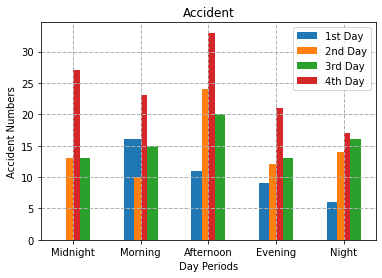

In [87]:
plot_holiday_periods(accident_day_periods(independence_df,"1st_Day"),
                     accident_day_periods(independence_df,"2nd_Day"),
                     accident_day_periods(independence_df,"3rd_Day"),
                     accident_day_periods(independence_df,"4th_Day"))

In [88]:
create_dataframe(accident_day_periods(christmast_df,"1st_Day"),
                accident_day_periods(christmast_df,"2nd_Day"),
                 accident_day_periods(christmast_df,"3rd_Day"),
                 accident_day_periods(christmast_df,"4th_Day"))

,Days,Midnight,Morning,Afternoon,Evening,Night,Total
0,1st_Day,14.0,40.0,63.0,81.0,33.0,231.0
1,2nd_Day,7.0,6.0,15.0,9.0,10.0,47.0
2,3rd_Day,7.0,4.0,6.0,11.0,28.0,56.0
3,4th_Days,12.0,10.0,2.0,18.0,10.0,52.0


In [89]:
df_ch=create_dataframe(accident_day_periods(christmast_df,"1st_Day"),
                accident_day_periods(christmast_df,"2nd_Day"),
                 accident_day_periods(christmast_df,"3rd_Day"),
                 accident_day_periods(christmast_df,"4th_Day"))

df_ch_sum=df_ch[["Midnight","Morning","Afternoon","Evening","Night"]].sum()
list_ch_sum=df_ch_sum.tolist()
hp.append(list_ch_sum)
list_ch_sum

[40.0, 60.0, 86.0, 119.0, 81.0]

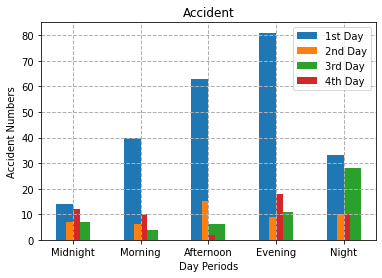

In [90]:
plot_holiday_periods(accident_day_periods(christmast_df,"1st_Day"),
                     accident_day_periods(christmast_df,"2nd_Day"),
                     accident_day_periods(christmast_df,"3rd_Day"),
                     accident_day_periods(christmast_df,"4th_Day"))

In [91]:
periods=["Midnight","Morning","Afternoon","Evening","Night"]
df = pd.DataFrame(hp, columns =periods, dtype = float)
df["Holiday"]=["Independence_Day","Christmast"]
df["Total"]=df["Midnight"]+df["Morning"]+df["Afternoon"]+df["Evening"]+df["Night"]


df["Midnight Rate"]=(df["Midnight"]/df["Total"])*100
df["Morning Rate"]=(df["Morning"]/df["Total"])*100
df["Afternoon Rate"]=(df["Afternoon"]/df["Total"])*100
df["Evening Rate"]=(df["Evening"]/df["Total"])*100
df["Night Rate"]=(df["Night"]/df["Total"])*100


df=df[["Holiday","Midnight Rate","Morning Rate","Afternoon Rate","Evening Rate","Night Rate","Total"]]
df

,Holiday,Midnight Rate,Morning Rate,Afternoon Rate,Evening Rate,Night Rate,Total
0,Independence_Day,16.932907,20.447284,28.115016,17.571885,16.932907,313.0
1,Christmast,10.362694,15.544041,22.279793,30.829016,20.984456,386.0


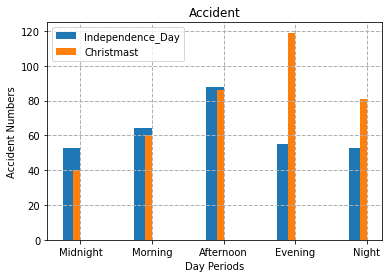

In [92]:
plt.bar([a for a in periods], hp[0], width= -0.25, label = 'Independence_Day', align='edge')
plt.bar([a for a in periods], hp[1], width= -0.10, label = 'Christmast', align='edge')

plt.title('Accident')
plt.xlabel('Day Periods')
plt.ylabel('Accident Numbers')
plt.legend(loc='upper left')
plt.xticks(periods)

plt.grid(True, linewidth= 1, linestyle="--")

In [93]:
kp=[]
day_numbers=["1st_Day","2nd_Day","3rd_Day","4th_day"]
kp.append(df_int["Total"].tolist())
kp.append(df_ch["Total"])

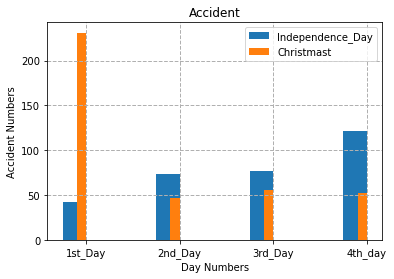

In [94]:
plt.bar([a for a in day_numbers], kp[0], width= -0.25, label = 'Independence_Day', align='edge')
plt.bar([a for a in day_numbers], kp[1], width= -0.10, label = 'Christmast', align='edge')

plt.title('Accident')
plt.xlabel('Day Numbers')
plt.ylabel('Accident Numbers')
plt.legend(loc='upper right')
plt.xticks(day_numbers)

plt.grid(True, linewidth= 1, linestyle="--")

In [95]:
def temp_accident(holiday_df, nth_Day):
    t_df=holiday_df.loc[holiday_df["Day_Number"]==nth_Day,["City","Temperature"]].groupby(["City"]).mean()
    t_df=t_df.reset_index()
    t_df=t_df.sort_values(by="City",ascending=True)
    
    a_df=holiday_df.loc[holiday_df["Day_Number"]==nth_Day,["City","ID"]].groupby(["City"]).count()
    a_df=a_df.reset_index()
    a_df=a_df.sort_values(by="City",ascending=True)
    
    ta_df=pd.merge(t_df,a_df,on=["City"],how="inner").dropna()
    ta_df=ta_df.sort_values(by="Temperature",ascending=False)
    return ta_df

In [96]:
def lineplot_temp_accident(temp1_accident_df,temp2_accident_df,temp3_accident_df,temp4_accident_df):
    fig, ax = plt.subplots(figsize=(50, 8))
    
    temp=[30,35,40,45,50,55]
    acc=[1,2,3,4,5,6,7,8,9,10,15,20,25,30,35]
    
    temp1= temp1_accident_df['Temperature'].tolist()
    acc1= temp1_accident_df['ID'].tolist()
    
    temp2=temp2_accident_df['Temperature'].tolist()
    acc2= temp2_accident_df['ID'].tolist()
    
    temp3=temp3_accident_df['Temperature'].tolist()
    acc3= temp3_accident_df['ID'].tolist()
    
    temp4=temp4_accident_df['Temperature'].tolist()
    acc4= temp4_accident_df['ID'].tolist()
    
    plt.plot(temp1,acc1,color = 'blue', label = '1st_Day')
    plt.plot(temp2,acc2,color='green', label = '2nd_Day')
    plt.plot(temp3,acc3,color='orange', label = '3rd_Day')
    plt.plot(temp4,acc4,color='red',label = '4th_Day')
    plt.xlabel('Average Temperature')
    plt.ylabel('Accident Numbers')
    plt.xticks(temp)
    plt.title('Accident Numbers depending on Average Temperature of Cities')
    plt.yticks(acc)
    plt.legend(loc='upper right')
    plt.grid(True, linewidth= 1, linestyle="--")

    return plt.show()

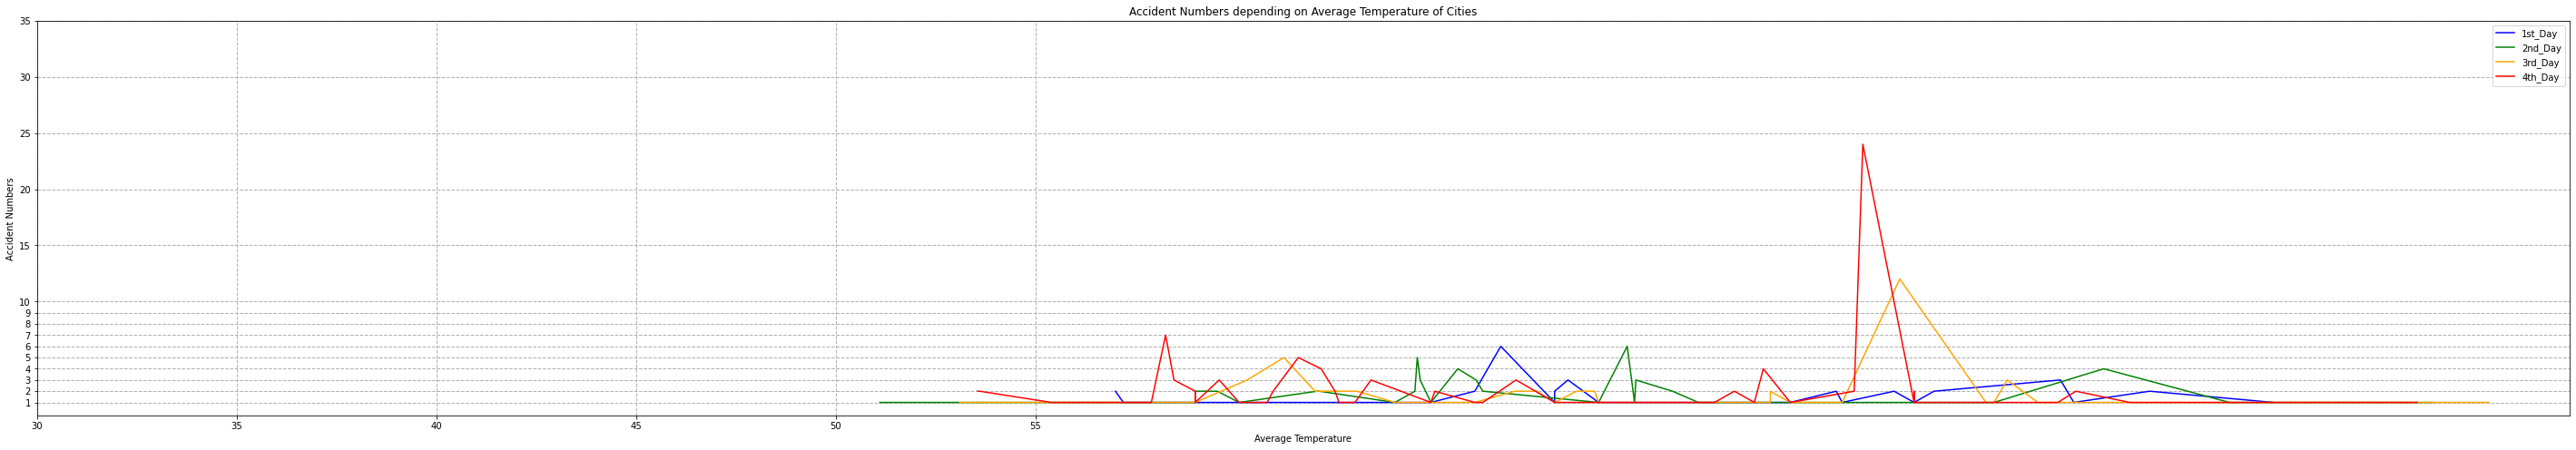

In [97]:
lineplot_temp_accident(temp_accident(independence_df,"1st_Day"),
                       temp_accident(independence_df,"2nd_Day"),
                       temp_accident(independence_df,"3rd_Day"),
                       temp_accident(independence_df,"4th_Day") 
                      )

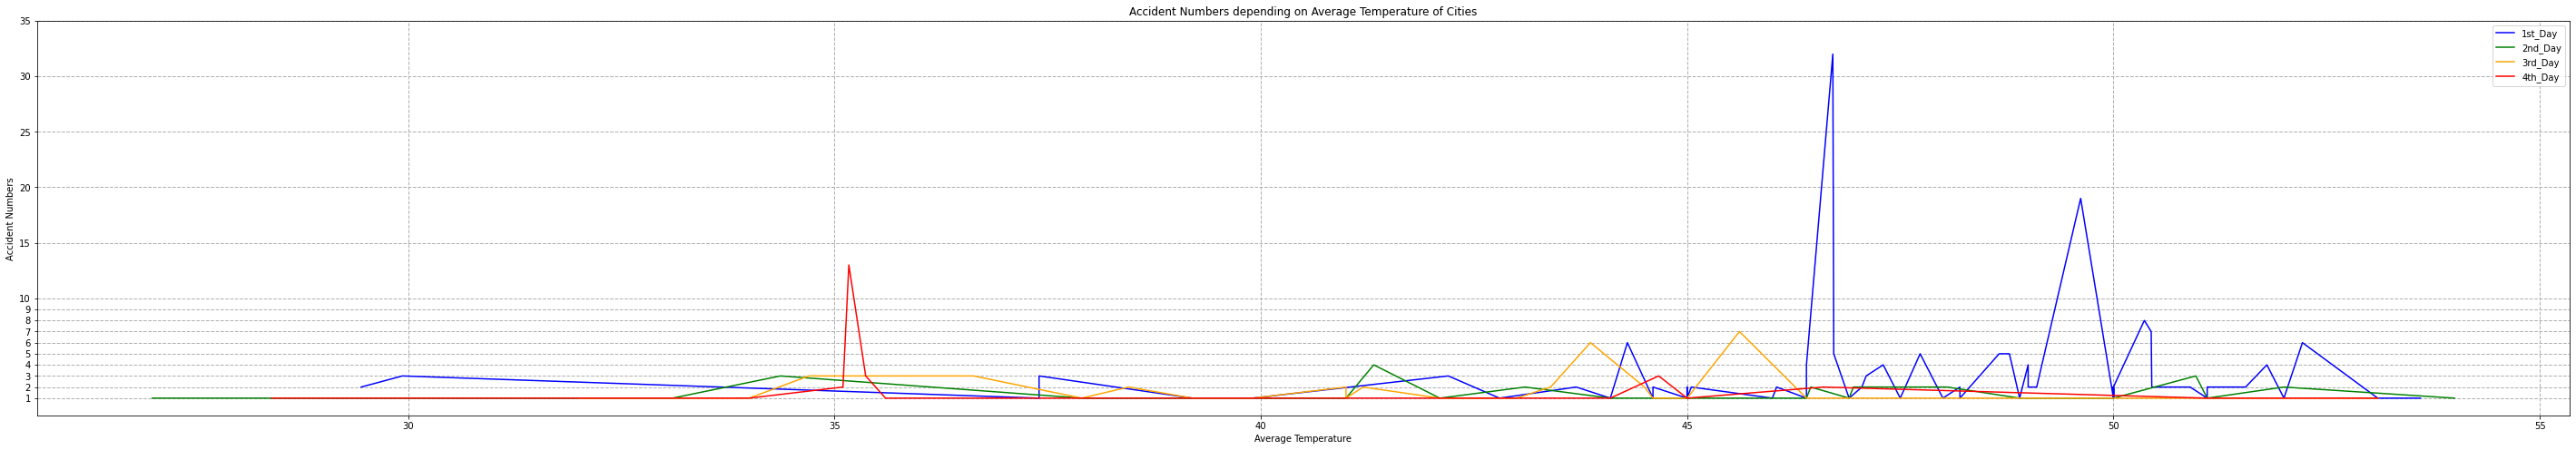

In [98]:
lineplot_temp_accident(temp_accident(christmast_df,"1st_Day"),
                       temp_accident(christmast_df,"2nd_Day"),
                       temp_accident(christmast_df,"3rd_Day"),
                       temp_accident(christmast_df,"4th_Day") 
                      )

In [99]:
def temp_accident(holiday_df, nth_Day):
    t_df=christmast_df.loc[christmast_df["Day_Number"]==nth_Day,["City","Temperature"]].groupby(["City"]).mean()
    t_df=t_df.reset_index()
    t_df=t_df.sort_values(by="City",ascending=True)
    
    a_df=christmast_df.loc[christmast_df["Day_Number"]==nth_Day,["City","ID"]].groupby(["City"]).count()
    a_df=a_df.reset_index()
    a_df=a_df.sort_values(by="City",ascending=True)
    
    ta_df=pd.merge(t_df,a_df,on=["City"],how="inner").dropna()
    ta_df=ta_df.sort_values(by="ID",ascending=False)
    return ta_df

In [100]:
d4_independence=temp_accident(independence_df, "4th_Day")
d4_independence.head(10)

,City,Temperature,ID
25,Sacramento,35.169231,13
26,San Francisco,44.666667,3
30,Tracy,35.366667,3
11,Lathrop,35.100000,2
18,Oakland,46.600000,2
24,Ripon,39.000000,1
20,Pinole,39.900000,1
21,Pleasanton,36.000000,1
22,Richmond,39.000000,1
23,Rio Linda,42.800000,1


In [101]:
d1_christmas=temp_accident(christmast_df, "1st_Day")
d1_christmas.head(10)

,City,Temperature,ID
70,Sacramento,46.709375,32
74,San Jose,49.615789,19
54,Oakland,50.362500,8
73,San Francisco,50.442857,7
12,Castro Valley,52.216667,6
81,Santa Rosa,44.300000,6
92,Tracy,48.780000,5
25,Fairfield,46.720000,5
97,Walnut Creek,47.733333,5
43,Los Gatos,48.660000,5
